In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from astropy.io import ascii


import sys 
sys.path.append('..')
from functions import *
# from colormaps import new_colors
cmap = plt.get_cmap('tab10')
new_colors = cmap(range(10))

3.0rc2


In [3]:
#tqkes several minutes to read in
UM_catalog_location = '/Users/fardila/Documents/Data/dwarf_lensing/UM/sfr_catalog_0.782092.txt'

UM_catalog = ascii.read(UM_catalog_location)

In [4]:
UM_catalog

ID,DescID,UPID,Flags,Uparent_Dist,X,Y,Z,VX,VY,VZ,M,V,MP,VMP,R,Rank1,Rank2,RA,RARank,SM,ICL,SFR,obs_SM,obs_SFR,SSFR,SM/HM,obs_UV
int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
2402494409,14114279,-1,2,2.0,15.11237,23.927719,39.993809,-101.650002,271.350006,-501.309998,98690000000000.0,682.359985,98690000000000.0,682.359985,898.609985,-0.191796,-0.944612,0.193902,0.006995,624200000000.0,185500000000.0,1.416,422900000000.0,0.8877,2.099e-12,0.006324,-18.478
117000000134642248,14114292,2402494409,8,0.280267,15.139074,23.706131,40.110489,3.06712,126.532379,-455.335754,1126000000.0,107.72628,40340000000.0,111.809998,20.232403,-0.168347,1.096783,0.355356,0.004981,5254000000.0,0.0,1.234,2799000000.0,0.703,2.512e-10,0.1303,-18.264
112000000220447759,14114305,2402494409,8,0.176275,15.21314,23.978075,39.88245,-390.766541,-116.732033,-296.937988,1031000000.0,85.856674,71320000000.0,118.209999,19.643745,-1.153136,1.50776,-0.080967,-1.321556,1668000000.0,0.0,0.001411,973800000.0,0.001118,1.148e-12,0.02338,-11.989
95000000587913536,14114348,2402494409,8,0.729134,14.620061,23.779465,40.399948,-115.190582,606.468506,-797.463684,14840000000.0,82.947815,132900000000.0,129.880005,47.781998,-1.40799,0.993044,0.141474,2.117998,14790000000.0,5602000.0,2.143,9873000000.0,5.984,6.06e-10,0.1113,-18.697
9000002264306060,14114412,2402494409,8,0.831355,15.032578,23.698879,40.70047,-153.646484,85.496735,1.4187,20340000000.0,62.033134,74750000000.0,86.099998,53.081776,-1.145341,0.823309,0.126857,-0.485957,248000000.0,11620000.0,0.1111,225400000.0,0.05377,2.385e-10,0.003317,-16.293
2402494410,14114279,2402494409,0,0.802979,14.73342,24.54076,39.958679,-285.0,948.179993,-628.169983,5697000000.0,33.59,16870000000.0,54.889999,34.73,-1.473392,2.143044,1.414695,-0.207874,19940000.0,0.0,0.008513,10020000.0,0.006396,6.384e-10,0.001182,0.0
2402494411,14114279,2402494409,0,0.281898,14.98934,24.08037,39.833401,762.840027,167.759995,411.970001,5241000000.0,30.110001,9116000000.0,32.0,33.778,0.053888,1.751088,-0.443672,0.176915,317900.0,0.0,0.0001543,274200.0,0.0004307,1.571e-09,3.487e-05,0.0
2402494412,14114279,2402494409,0,0.84827,14.85569,24.49477,39.553791,-118.650002,741.169983,-360.0,2963000000.0,20.66,7976000000.0,44.580002,27.927999,-2.17918,1.864711,0.386926,-0.697525,1929000.0,0.0,2.767e-06,855300.0,2.158e-06,2.524e-12,0.0002418,0.0
2402494413,14114279,2402494409,0,0.742892,14.8217,24.481701,39.76086,-26.35,869.400024,-1179.97998,2507000000.0,25.049999,3874000000.0,36.619999,26.416,-1.473994,2.021893,2.2655,-0.079813,668200.0,0.0,0.0003317,507100.0,9.43e-05,1.859e-10,0.0001725,0.0


In [19]:
UM_catalog['stellar_mass'] = np.log10(UM_catalog['obs_SM'])

In [8]:
run='Vmax_5'
config = parse_config('/Users/fardila/Documents/GitHub/dwarf_lensing/MCMC/config/mcmc_config_{0}.yaml'.format(str(run)))
config, cosmos_data, sim_data = initial_model(config)


5SHMR+scatter (Vmax@Mpeak)


In [46]:
def compute_deltaSigma_UM(UM_catalog, config, cosmos_data, sim_data):

    n_nearest = 90

    # select subsample of dwarfs from galaxy catalog
    # galaxies have the same positions as subhalos
    mock_galaxies = UM_catalog['stellar_mass','X', 'Y', 'Z']
    mock_galaxies = np.array(mock_galaxies[(mock_galaxies['stellar_mass']>=min(cosmos_data['cosmos_dwarf_masses'])) & \
                                      (mock_galaxies['stellar_mass']<9.0)])
    # half_mock_galaxies = np.random.choice(mock_galaxies,500000)
    print('cut galaxies table', len(mock_galaxies))


    galaxies_table= create_dwarf_catalog_with_matched_mass_distribution(cosmos_data['cosmos_dwarf_masses'],
                                                                    mock_galaxies,
                                                                    n_nearest = n_nearest)

    print(ks_2samp(galaxies_table['stellar_mass'],cosmos_data['cosmos_dwarf_masses']))
    if ks_2samp(galaxies_table['stellar_mass'],cosmos_data['cosmos_dwarf_masses'])[1] < 0.95:
        print('Mock and COSMOS distributions don\'t match!')

    # read in galaxy positions
    x = galaxies_table['X'] % config['sim_lbox']
    y = galaxies_table['Y'] % config['sim_lbox']
    z = galaxies_table['Z'] % config['sim_lbox']
    galaxies = np.vstack((x, y, z)).T

    # mass enclosed by cylinders around each galaxy
    period=np.ones(3)*config['sim_lbox']
    r_bins = np.logspace(-2.1,0,20)

    mass_encl = total_mass_enclosed_per_cylinder(galaxies, sim_data['particles'],
                                                 sim_data['particle_masses'],
                                                 sim_data['downsampling_factor'],
                                                 r_bins, period)

    # delta Sigma
    rp, ds = delta_sigma_from_precomputed_pairs(galaxies, mass_encl, r_bins,
                                                period, cosmology=config['sim_cosmo'])

    #convert to correct physical units
    ds = ds/1e12 # convert units pc^-2 --> Mpc^-2
    ds = ds*config['sim_h0']*((1+config['sim_z'])**2) #convert from comoving to physical
    rp = rp / float(config['sim_h0']*(1+config['sim_z'])) #convert from comoving to physical

    return rp, ds


## create 5 files to smooth out 

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


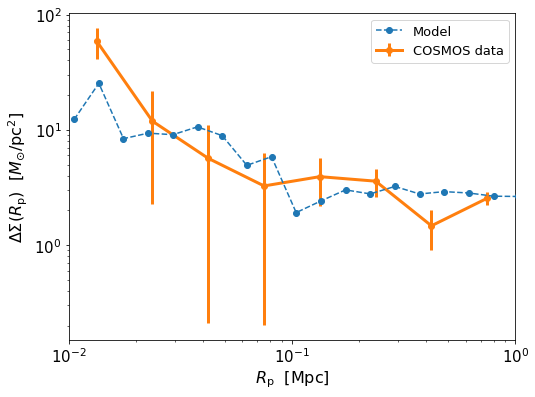

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


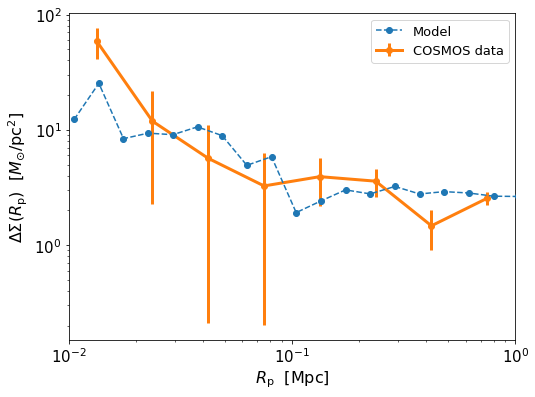

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


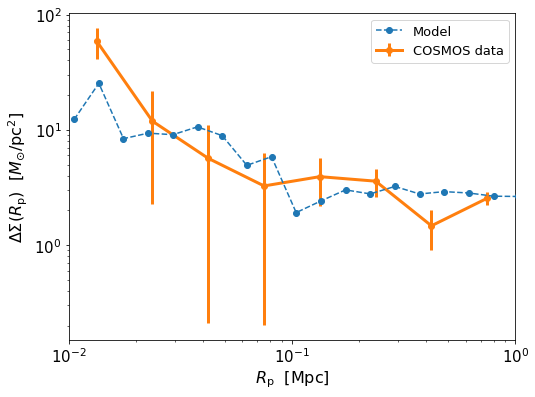

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


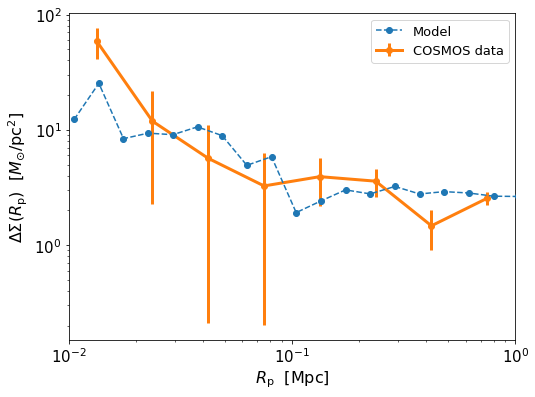

('cut galaxies table', 1677428)
Ks_2sampResult(statistic=0.002423366411199779, pvalue=0.9999999999994739)


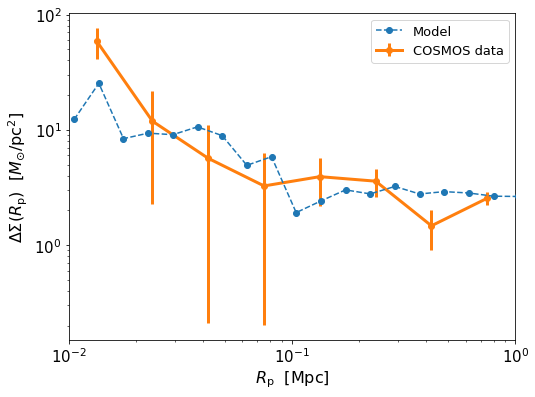

In [49]:
for i in range(5):
    # Predict DeltaSigma profiles
    wl_r, wl_ds = compute_deltaSigma_UM(UM_catalog, config, cosmos_data, sim_data)
    plot_deltaSigma(cosmos_data['cosmos_wl_table'], wl_r, wl_ds)
    np.savetxt('/Users/fardila/Documents/GitHub/dwarf_lensing/mock_dwarfs/UM_dwarfs_WL_profile_{0}.txt'.format(str(i)),
               np.c_[wl_r,wl_ds], header = 'R DS')
    
    